<a href="https://colab.research.google.com/github/TechRoC/Human-Face-Generator/blob/master/Generative_Adverseria_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import * 
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
import time
from tensorflow.keras import backend as K


100%|██████████| 10000/10000 [2:15:23<00:00,  1.23it/s]


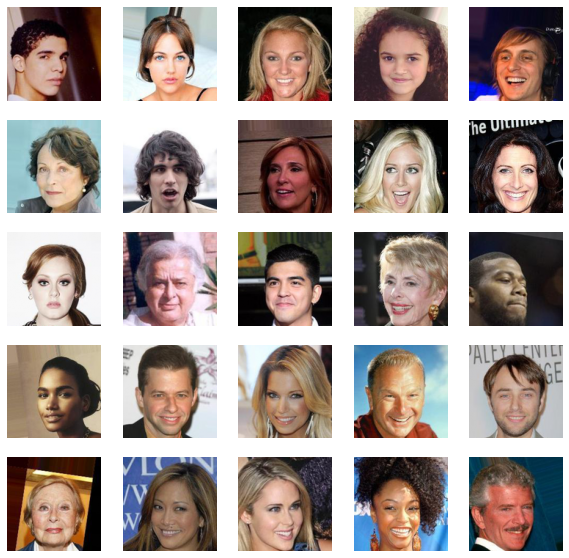

In [ ]:
from tqdm import tqdm
from PIL import  Image
PIC_DIR = '/content/drive/My Drive/image/'
IMAGES_COUNT = 10000
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
WIDTH = 128
HEIGHT = 128
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))
#Normalize the images                                                                              
images = np.array(images) / 255
images.shape
#print first 25 images
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)                             
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:

image_size =  images.shape[1]

In [ ]:
def build_generator(inputs, image_size):

    image_resize = image_size // 8

    kernel_size = 5
    layer_filters = [256, 256, 512]

    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        strides = 2
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)
        x = LeakyReLU()(x)
    x = Conv2D(filters=3,
                   kernel_size=kernel_size,
                   strides=1,
                   padding='same')(x)
    x = Activation('tanh')(x)
    generator = Model(inputs, x, name='generator')
    return generator

In [ ]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs
    for filters in layer_filters:
       
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU()(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    return discriminator

In [ ]:
def train(models, x_train, params):

    
    generator, discriminator, adversarial = models
   
    batch_size, latent_size, train_steps, model_name = params
   
    save_interval = 500
    
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    
    train_size = x_train.shape[0]
    images_saved = 0
    for i in range(train_steps):
       
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        
        fake_images = generator.predict(noise)
        
        x = np.concatenate((real_images, fake_images))
      
        y = np.ones([2 * batch_size, 1])
        
        y[batch_size:, :] = 0.0
      
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

       
        noise = np.random.uniform(-1.0,
                                  1.0, 
                                  size=[batch_size, latent_size])
        
        y = np.ones([batch_size, 1])
        
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)

        if (i + 1) % save_interval == 0:
            plot_images(generator,
                        noise_input=noise_input,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
   

    generator.save(model_name + ".h5")


In [ ]:
def plot_images(generator,
                noise_input,
                show=False,
                step=0,
                model_name="gan"):
  
    from PIL import Image
    import numpy as np 
    CHANNELS = 3
    ORIG_WIDTH = 178
    ORIG_HEIGHT = 208
    diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
    LATENT_DIM = 32
    WIDTH = 128
    HEIGHT = 128
    crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    CONTROL_SIZE_SQRT = 6
    control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
    images_saved = 0
    control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
    control_generated = generator.predict(control_vectors)
    for i in range(CONTROL_SIZE_SQRT ** 2):
      x_off = i % CONTROL_SIZE_SQRT
      y_off = i // CONTROL_SIZE_SQRT
      control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
    im = Image.fromarray(np.uint8(control_image * 255))
    im.save(filename)
'''
    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    print(images.shape,images.size,num_images)
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    images = np.reshape(images, [-1, image_size, image_size, 3])
    images = images.astype('float32') * 255
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = images[i]
        
        plt.imshow(image)
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')
'''

"\n    images = generator.predict(noise_input)\n    plt.figure(figsize=(10, 10))\n    num_images = images.shape[0]\n    print(images.shape,images.size,num_images)\n    image_size = images.shape[1]\n    rows = int(math.sqrt(noise_input.shape[0]))\n    images = np.reshape(images, [-1, image_size, image_size, 3])\n    images = images.astype('float32') * 255\n    for i in range(num_images):\n        plt.subplot(rows, rows, i + 1)\n        image = images[i]\n        \n        plt.imshow(image)\n        plt.axis('off')\n    plt.savefig(filename)\n    if show:\n        plt.show()\n    else:\n        plt.close('all')\n"

In [ ]:
def build_and_train_models(image_size,images):

    images = images
    image_size = image_size

    model_name = "dcgan_mnist"
    latent_size = 32
    batch_size = 16
    train_steps = 10000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 3)

    
    inputs = Input(shape=input_shape, name='discriminator_input')
    discriminator = build_discriminator(inputs)

    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    
    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
  
    discriminator.trainable = False
   
    adversarial = Model(inputs, 
                        discriminator(generator(inputs)),
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy'
    ,
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()

    
    models = (generator, discriminator, adversarial)
    params = (batch_size,
              latent_size, 
              train_steps,
              model_name)
    train(models, images, params)
build_and_train_models(image_size,images)

Streaming output truncated to the last 5000 lines.
2129: [discriminator loss: 0.729976, acc: 0.500000] [adversarial loss: 0.790547, acc: 0.312500]
2130: [discriminator loss: 0.762764, acc: 0.437500] [adversarial loss: 0.797100, acc: 0.187500]
2131: [discriminator loss: 0.664154, acc: 0.593750] [adversarial loss: 0.814095, acc: 0.000000]
2132: [discriminator loss: 0.676417, acc: 0.468750] [adversarial loss: 0.792073, acc: 0.250000]
2133: [discriminator loss: 0.677845, acc: 0.593750] [adversarial loss: 0.624202, acc: 0.812500]
2134: [discriminator loss: 0.642706, acc: 0.593750] [adversarial loss: 1.024244, acc: 0.000000]
2135: [discriminator loss: 0.701327, acc: 0.593750] [adversarial loss: 0.548689, acc: 0.812500]
2136: [discriminator loss: 0.705001, acc: 0.500000] [adversarial loss: 0.985301, acc: 0.000000]
2137: [discriminator loss: 0.701021, acc: 0.625000] [adversarial loss: 0.628403, acc: 0.625000]
2138: [discriminator loss: 0.682243, acc: 0.406250] [adversarial loss: 0.823004, acc: